In [10]:
import sys
sys.path.append("..")  # Adds the parent directory to the sys.path

from utitlity_functions import *
import numpy as np
from confectionery import Confectionery
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import scienceplots
import cv2 as cv
from matplotlib import cm
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
np.random.seed(137)

# Load all necessary Data

In [11]:
object_trajectory=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/data/obj_traj_1.npy")
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
start_frame=round(object_trajectory[0,0])
end_frame=round(object_trajectory[-1,0])
stream_string=[]
for i in range(start_frame,end_frame+1):
    im_path="Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t"+str(i).zfill(3)+".jpg"
    stream_string.append(im_path)
koppenrath=Confectionery()
# load normal trajectories
normal_vector_trajectory=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/data/normal_vector_trajectory_1.npy")
rotation_trajectory=calculate_rotations_from_normal_vector_trajectory(normal_vector_trajectory)

# Calculate groundcontact points on sphere

In [12]:
n_start=normal_vector_trajectory[:,0]
n_bottom=np.array([0,0,-1])
n_rot=np.cross(n_start,n_bottom)
if np.linalg.norm(n_start-n_bottom)<1e-6:
    R_bottom=R.from_matrix(np.eye(3))
elif np.linalg.norm(n_start+n_bottom)<1e-6:
    R_bottom=R.from_euler('x', np.pi)
else:
    angle_bottom=np.arctan2(np.linalg.norm(n_rot),np.dot(n_start,n_bottom))
    n_rot=n_rot/np.linalg.norm(n_rot)
    R_bottom=R.from_rotvec(n_rot*angle_bottom)
pts_bottom=R_bottom.apply(np.transpose(normal_vector_trajectory))

In [13]:
phi=[]
tangent_vector=np.cross(rotation_trajectory[0].as_rotvec(),normal_vector_trajectory[:,0])
x_axis_tangent_0=tangent_vector/np.linalg.norm(tangent_vector)
y_axis_tangent_0=np.cross(normal_vector_trajectory[:,0],x_axis_tangent_0)
z_axis_tangent_0=normal_vector_trajectory[:,0]
A_0=np.array([x_axis_tangent_0,y_axis_tangent_0,z_axis_tangent_0])
A_0=np.transpose(A_0)

A=[A_0]
for i in range(1,len(rotation_trajectory)):
    if np.linalg.norm(rotation_trajectory[i].as_rotvec())>1e-6:
        tangent_vector=np.cross(rotation_trajectory[i].as_rotvec(),normal_vector_trajectory[:,i])
        x_axis_tangent=tangent_vector/np.linalg.norm(tangent_vector)
        y_axis_tangent=np.cross(normal_vector_trajectory[:,i],x_axis_tangent)
        z_axis_tangent=normal_vector_trajectory[:,i]
        B=np.array([x_axis_tangent,y_axis_tangent,z_axis_tangent])
        B=np.transpose(B)
        B=rotation_trajectory[i].as_matrix().T@B
        A.append(B)
    else:
        A.append(B)
A=np.array(A)
A=A[:,0]
for i in range(1,len(rotation_trajectory)):
    n1=A[0,:]
    n2=A[i,:]
    n_axis=np.cross(n1,n2)
    if np.linalg.norm(n_axis)<1e-6:
        phi.append(0)
    else:
        phi.append(np.arctan2(np.linalg.norm(n_axis),np.dot(n1,n2)))
phi=np.array(phi)


In [14]:
X=np.zeros((2,1))
phi=phi
radius=np.mean(object_trajectory[:,-1])
angles=np.array([np.linalg.norm(x.as_rotvec()) for x in rotation_trajectory.values()])
for i in range(phi.size):
    x_next=X[:,-1]+radius*angles[i]*np.array([np.cos(phi[i]),np.sin(phi[i])])
    x_next=x_next.reshape((2,1))
    X=np.append(X,x_next,axis=1)

initial_directions_angle=130*np.pi/180
S=np.array([[np.cos(initial_directions_angle),-np.sin(initial_directions_angle)],
            [np.sin(initial_directions_angle),np.cos(initial_directions_angle)]
            ])
X=S@X
X=X+np.array([object_trajectory[0,1],object_trajectory[0,2]]).reshape((2,1))

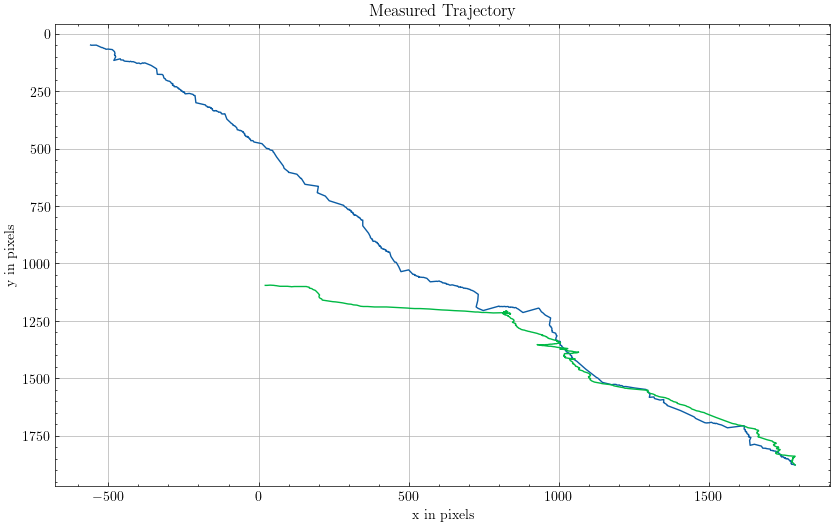

In [15]:
X_true=object_trajectory[:,1]
Y_true=object_trajectory[:,2]
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.plot(X[0,:],X[1,:])
    plt.plot(X_true,Y_true)
    plt.grid()
    plt.gca().invert_yaxis()
    plt.title("Measured Trajectory")
    plt.show()


In [16]:
dX=np.diff(X[0,:])
dY=np.diff(X[1,:])
L=np.add.accumulate(np.sqrt(dX**2+dY**2))
L[-1]

3637.954325846122

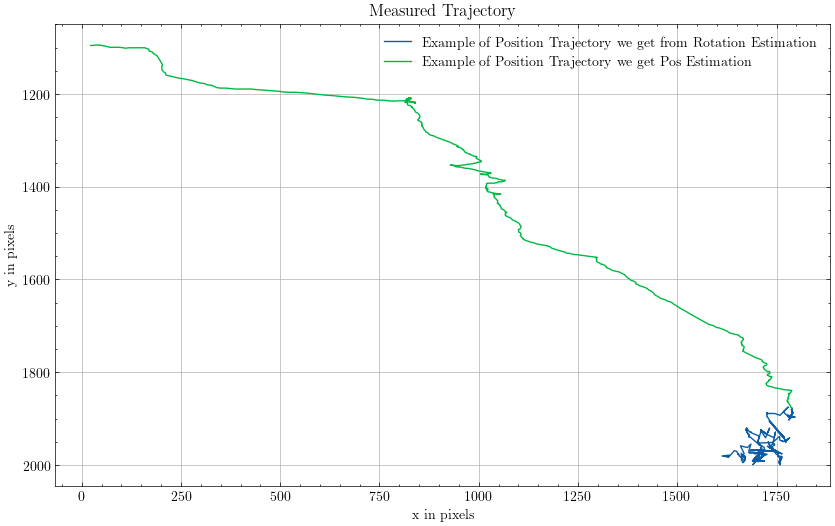

In [20]:
axis_rot=np.array([x.as_rotvec() for x in rotation_trajectory.values()])
v_flat=np.copy(axis_rot[:,[1,0]])
v_flat[:,1]=-v_flat[:,1]
normalization_factor=[np.linalg.norm(x) for x in v_flat]
normalization_factor=np.array([x if x>1e-6 else 1 for x in normalization_factor])
v_flat=v_flat/normalization_factor[:,np.newaxis]


r=np.mean(object_trajectory[:,-1])
p_0=np.array([0,0,1])
dist=distance_rot_on_sphere(p_0,rotation_trajectory,r)
dist=dist[1:]-dist[:-1]

V=dist[:,np.newaxis]*v_flat
V=np.concatenate((np.array([object_trajectory[0,1],object_trajectory[0,2]]).reshape((1,2)),V),axis=0)
pos=np.add.accumulate(V)
X_true=object_trajectory[:,1]
Y_true=object_trajectory[:,2]
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.plot(pos[:,0],pos[:,1],label="Example of Position Trajectory we get from Rotation Estimation")
    plt.plot(X_true,Y_true, label="Example of Position Trajectory we get Pos Estimation")
    plt.grid()
    plt.gca().invert_yaxis()
    plt.title("Measured Trajectory")
    plt.legend()
    plt.show()

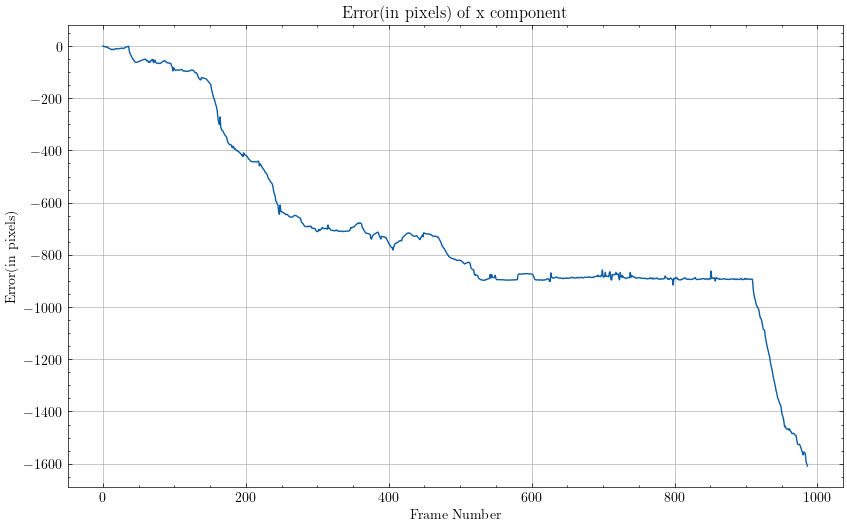

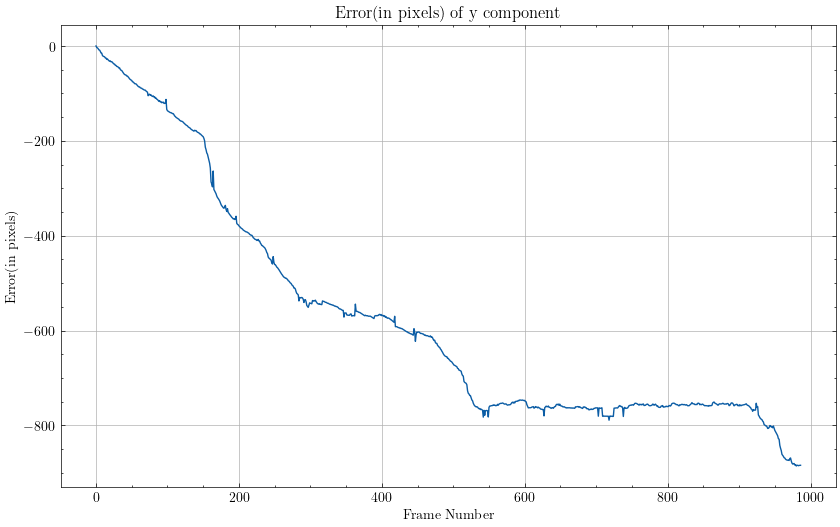

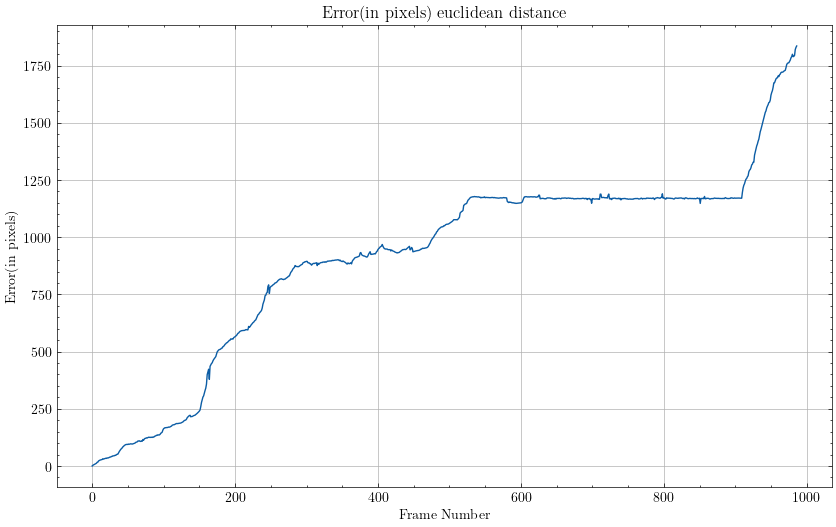

In [18]:
error_x=object_trajectory[:,1]-pos[:,0]
error_y=object_trajectory[:,2]-pos[:,1]
error_euclidean_dist=np.linalg.norm(object_trajectory[:,1:3]-pos,axis=1)
t=np.arange(error_x.size)
with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.xlabel("Frame Number")
    plt.ylabel("Error(in pixels)")
    plt.plot(t,error_x)
    plt.grid()
    plt.title("Error(in pixels) of x component")
    plt.show()


with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.xlabel("Frame Number")
    plt.ylabel("Error(in pixels)")
    plt.plot(t,error_y)
    plt.grid()
    plt.title("Error(in pixels) of y component")
    plt.show()

with plt.style.context('science'):
    plt.rcParams['figure.figsize'] = [10, 6]
    plt.xlabel("Frame Number")
    plt.ylabel("Error(in pixels)")
    plt.plot(t,error_euclidean_dist)
    plt.grid()
    plt.title("Error(in pixels) euclidean distance")
    plt.show()


# save flat position vector from rot

In [19]:
folder="/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/plot_folder/data/"
np.save(folder+str("obj_0_pos_from_rot.npy"),pos)